<a href="https://colab.research.google.com/github/biaferre/interactive-quantum-regressor/blob/dev/IQRegressor_Linear_TailFIx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install toqito

In [ ]:
!pip install qiskit

In [ ]:
import pandas as pd
from scipy.linalg import expm as expMatrix
from scipy.stats import unitary_group
from sympy import Matrix
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, make_scorer, roc_auc_score, classification_report
from sklearn.model_selection import KFold
from toqito import state_props
import itertools
from qiskit.quantum_info import Operator, partial_trace
from qiskit import QuantumCircuit
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np

## Dataset

In [ ]:
def create_linear_regression_dataset(n_samples=100,
                                     slope=2.0,
                                     intercept=1.0,
                                     noise=0.1,
                                     x_range=(0, 0.5),
                                     random_seed=42):
    """
    Creates a simple linear regression dataset: y = slope * x + intercept + noise

    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    slope : float
        Slope of the line (m in y = mx + b)
    intercept : float
        Y-intercept of the line (b in y = mx + b)
    noise : float
        Standard deviation of Gaussian noise added to y values
    x_range : tuple
        Range of x values (min, max)
    random_seed : int
        Random seed for reproducibility

    Returns:
    --------
    X : numpy array of shape (n_samples, 1)
        Input features (x values)
    y : numpy array of shape (n_samples,)
        Target values (y values)
    """
    np.random.seed(random_seed)

    # Generate x values uniformly distributed in the given range
    X = np.random.uniform(x_range[0], x_range[1], n_samples)

    # Generate y values: y = slope * x + intercept + noise
    y = slope * X + intercept + np.random.normal(0, noise, n_samples)

    # Reshape X to be 2D (required by scikit-learn)
    X = X.reshape(-1, 1)

    return X, y

In [ ]:
def plot_regression_dataset(X, y, y_pred=None, title="Linear Regression Dataset"):
    """
    Plot the regression dataset and optionally the predictions

    Parameters:
    -----------
    X : numpy array
        Input features
    y : numpy array
        True target values
    y_pred : numpy array, optional
        Predicted target values
    title : str
        Plot title
    """
    plt.figure(figsize=(10, 6))

    # Plot actual data points
    plt.scatter(X, y, alpha=0.6, label='Actual data', color='blue')

    # Plot predictions if provided
    if y_pred is not None:
        # Sort by X for proper line plotting
        sorted_indices = np.argsort(X.flatten())
        plt.plot(X[sorted_indices], y_pred[sorted_indices],
                color='red', linewidth=2, label='Predictions')

    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

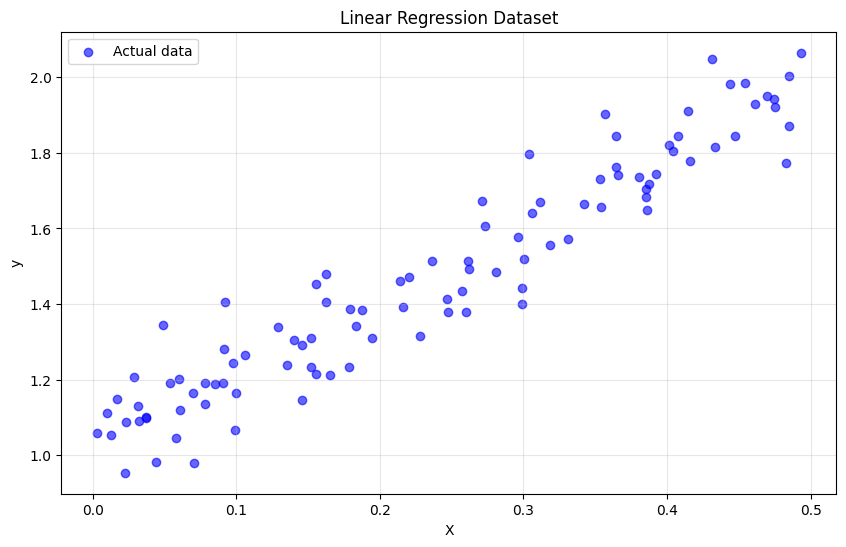

In [ ]:
X, y = create_linear_regression_dataset()
plot_regression_dataset(X, y)

## Classe IQC Regressor

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import numpy as np

class IQCRegressor(RegressorMixin, BaseEstimator):
    def __init__(self,
                 regressor_function,
                 dic_regressor_params,
                 dic_training_params):

        self.regressor_function = regressor_function
        self.dic_regressor_params = dic_regressor_params
        self.dic_training_params = dic_training_params
        self.mse_threshold = dic_training_params.get("mse_threshold", 0.01)  # Stop when MSE is below this
        self.max_iter = dic_training_params["max_iter"]
        self.reset_weights_epoch = dic_training_params.get("reset_weights_epoch", None)
        self.random_seed = dic_training_params["random_seed"]
        self.learning_rate = dic_training_params["learning_rate"]
        self.plot_graphs_and_metrics = dic_training_params.get("plot_graphs_and_metrics", False)
        self.batch = dic_training_params.get("batch", 1)

        if "coupling_constants" not in self.dic_training_params:
            dic_training_params["coupling_constants"] = [1]
        self.coupling_constants = dic_training_params["coupling_constants"]

        self.negativity_ = []
        self.entropy_ = []
        self.y_scaler_ = MinMaxScaler(feature_range=(-1, 1))

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        # Store training data
        self.n_features_in_ = X.shape[1]

        y_scaled = self.y_scaler_.fit_transform(y.reshape(-1, 1)).flatten()

        # Creates weights based on a [-1, 1] uniform distribution
        low = -1
        high = 1
        dimensions = len(X[0])
        num_of_instances = len(X)

        # Setting random seed for reproducibility
        np.random.seed(self.random_seed)
        weights = []
        for _ in self.dic_training_params["coupling_constants"]:
            weights.append(np.random.uniform(low=low, high=high, size=(dimensions,)))

        ITERATION = 0
        best_weight = None
        best_mse = float('inf')
        mse = float('inf')
        self.mse_during_training_ = []

        # No need to calculate negativity/entropy during training
        self.dic_regressor_params["calculate_negativity"] = False
        self.dic_regressor_params["calculate_entropy"] = False

        # Executing the training itself
        while ITERATION < self.max_iter and mse > self.mse_threshold:
            accumulated_loss = np.zeros((dimensions))
            predictions = []

            # Training step
            for i, (x_train, y_train) in enumerate(zip(X, y_scaled)):
                # Execute the regressor with current weights
                expectation, p_cog, _ = self.regressor_function(
                    vector_x=x_train,
                    vector_ws=weights,
                    dic_classifier_params=self.dic_regressor_params
                )

                predictions.append(expectation)

                # Calculate error (difference between prediction and target)
                error = expectation - y_train
                accumulated_loss += error * x_train

                # Update weights
                if self.batch <= 1:
                    # Update after each sample
                    weights = self._update_weights(
                        weights, y_train, expectation, x_train, p_cog,
                        n=self.learning_rate,
                        coupling_constants=self.coupling_constants
                    )
                elif i % self.batch == 0 or i == num_of_instances - 1:
                    # Batch update
                    weights = self._update_batched_weights(
                        weights, accumulated_loss/self.batch,
                        self.learning_rate,
                        coupling_constants=self.coupling_constants
                    )
                    accumulated_loss = np.zeros((dimensions))

            # Calculate MSE for this epoch
            mse = np.mean((np.array(predictions) - y_scaled) ** 2)
            self.mse_during_training_.append(mse)
            ITERATION += 1

            # Save best weights (lowest MSE)
            if mse < best_mse or ITERATION == 1:
                best_weight = weights.copy()
                best_mse = mse

        self.mse_ = best_mse
        self.weight_ = best_weight
        self.X_ = X
        self.y_ = y_scaled

        if self.plot_graphs_and_metrics:
            print("Best weight:", best_weight)
            print("Best MSE:", best_mse)
            print(f"Converged in {ITERATION} iterations")

        return self

    def predict(self, X):
        """
        Returns the predicted continuous values for each X instance.
        """
        # Check if fit has been called
        check_is_fitted(self, ['X_', 'y_', 'weight_'])

        # Input validation
        X = check_array(X)

        # Make predictions for each instance
        predictions = []
        self.negativity_ = []
        self.entropy_ = []
        self.dic_regressor_params["calculate_negativity"] = True
        self.dic_regressor_params["calculate_entropy"] = True

        for x in X:
            expectation, p_cog, output_dict = self.regressor_function(
                vector_x=x,
                vector_ws=self.weight_,
                dic_classifier_params=self.dic_regressor_params
            )

            predictions.append(expectation)

            self.negativity_.append(output_dict["negativity"])
            self.entropy_.append(output_dict["entropy"])

        # Calculate mean negativity and entropy
        predictions = np.array(predictions)

        # print(f"original predictions: {predictions}")

        predictions_original_scale = self.y_scaler_.inverse_transform(
              predictions.reshape(-1, 1)
            ).flatten()

        self.negativity_ = np.mean(self.negativity_)
        self.entropy_ = np.mean(self.entropy_)

        return predictions_original_scale

    def _update_weights(self, weights, y_true, y_pred, x, p_cog, n, coupling_constants):
        """
        Update weights for single sample (gradient descent step for regression).

        For regression: w_new = w_old - learning_rate * gradient
        where gradient = (y_pred - y_true) * x
        """
        error = y_pred - y_true
        new_weights = []

        for i, (weight, coupling) in enumerate(zip(weights, coupling_constants)):
            # Gradient descent update
            gradient = error * (1 - (p_cog ** 2)) * x * coupling
            new_weight = weight - n * gradient
            new_weights.append(new_weight)

        return new_weights

    def _update_batched_weights(self, weights, accumulated_loss, learning_rate, coupling_constants):
        """
        Update weights using accumulated gradients from a batch.
        """
        new_weights = []

        for i, (weight, coupling) in enumerate(zip(weights, coupling_constants)):
            gradient = accumulated_loss * coupling
            new_weight = weight - learning_rate * gradient
            new_weights.append(new_weight)

        return new_weights

    def score(self, X, y):
        """
        Return the coefficient of determination R² of the prediction.

        R² = 1 - (SS_res / SS_tot)
        where SS_res = sum((y_true - y_pred)²)
              SS_tot = sum((y_true - y_mean)²)
        """
        from sklearn.metrics import r2_score

        y_pred = self.predict(X)
        return r2_score(y, y_pred)

In [ ]:
def iqc_regressor(vector_x,
                   vector_ws,
                   normalize_x=False,
                   normalize_w=False,
                   dic_classifier_params={},
                   N_qubits=None,
                   N_qubits_tgt=None):
    # IQ system for regressor

    N = len(vector_x)

    if "sigma_q_params" in dic_classifier_params:
        sigma_q_params = dic_classifier_params["sigma_q_params"]
    if "use_polar_coordinates_on_sigma_q" in dic_classifier_params:
        use_polar_coordinates_on_sigma_q = dic_classifier_params["use_polar_coordinates_on_sigma_q"]


    if normalize_x:
        vector_x = normalize(vector_x)
    if "use_exponential_on_input" in dic_classifier_params and dic_classifier_params["use_exponential_on_input"]:
        vector_x = np.exp(vector_x)

    if (use_polar_coordinates_on_sigma_q):
        # Eq #16, but using polar coordinates so |sigmaQ| gets to be 1
        sigmaQ = get_sigmaQ_from_polar_coord(sigma_q_params)
    else:
        # Eq #16
        sigmaQ = get_weighted_sigmaQ(sigma_q_params)

    # We want to have multiple environments, thus we need to have a list of weights for each of them
    if not(isinstance(vector_ws, (list, np.ndarray)) and all(isinstance(item, (list, np.ndarray)) for item in vector_ws)):
        vector_ws = np.array(vector_ws, dtype=complex)

    # Eq 25
    p_env = np.ones((N,1))/np.sqrt(N)
    p_env = get_p(p_env)

    # Our first p_cog will be the original one, but will change overtime
    p_cog = np.ones((2,1)) / np.sqrt(2)
    # Eq #18
    p_cog = get_p(p_cog)

    # We'll update the p_cog for every env we have
    p_cog_new = p_cog
    U_operators = []
    for vector_w in vector_ws:
        if normalize_w:
            vector_w = normalize(vector_w)

        # Equivalent to Eq #15
        sigmaE = get_sigmaE(vector_x, vector_w, dic_classifier_params)

        U_operator = get_U_operator(sigmaQ, sigmaE)
        U_operators.append(U_operator)

        # Extracting p_cog and p_env kron
        p_cog_env = np.kron(p_cog_new, p_env)

        # First part of Equation #20 in the Article
        p_out = np.array(U_operator * p_cog_env * U_operator.getH())

        # Second part of Equation #20 in the Article
        # For multiple environemnts, this will be our new p_cog
        p_cog_new = np.trace(p_out.reshape([2,N,2,N]), axis1=1, axis2=3)

    # Extract diagonal probabilities (can be used as confidence metrics)
    p_cog_new_00 = np.real(p_cog_new[0,0])
    p_cog_new_11 = np.real(p_cog_new[1,1])

    # Calculate expectation value using Pauli-Z operator
    expectation = np.real(np.trace(p_cog_new @ np.array([[1,0],[0,-1]])))
    # expectation_v2 = np.array([[p_cog_new_00, p_cog_new_11]]) @ np.array([[1,0],[0,-1]]) @ np.array([[p_cog_new_00],[p_cog_new_11]])

    # print(f"Testing expectation method\n Original: {expectation}, New: {expectation_v2}")

    output_dict = {}
    output_dict["U_operators"] = U_operators
    output_dict["p_00"] = p_cog_new_00  # Additional info
    output_dict["p_11"] = p_cog_new_11  # Additional info

    if "calculate_negativity" in dic_classifier_params and dic_classifier_params["calculate_negativity"]:
        output_dict["negativity"] = get_negativity(p_out, [2, N])

    if "calculate_entropy" in dic_classifier_params and dic_classifier_params["calculate_entropy"]:
        output_dict["entropy"] = get_entropy(p_out)

    # Return 3 values like the classifier
    return expectation, p_cog_new_11, output_dict

## Métodos

In [ ]:
def print_and_save_weights(weights, model, print_all=False):
    """
        Prints and saves the best weights used in the training.
        Weights are saved in a CSV file with the current date.
    """
    if print_all:
        print("Weights:", weights)

    # Preparação do DataFrame para salvar
    data_to_save = {
        'Weights': weights
    }

    weights_df = pd.DataFrame(data_to_save)

    # Nome do arquivo com data atual
    current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{model}_weights_{current_date}.csv"

    # Salvando em CSV
    weights_df.to_csv(filename, index=False)
    print(f"\nWeights saved in: {filename}")

In [ ]:
def print_and_save_negativity(negativities, model, print_all=False):
    """
        Prints and saves the mean negativity per class obtained in the training.
        Negativity is saved in a CSV file with the current date.
    """

    negativities_metrics = {
        f"Negativity_Class_{i}": {
            "Mean": np.mean(values),
            "Std_Error": np.std(values, ddof=1) / np.sqrt(len(values))
        }
        for i, values in enumerate(negativities)
    }

    if print_all:
        print("Negativity:", negativities)

    # Preparação do DataFrame para salvar
    for i, metrics in negativities_metrics.items():
        print(f"{i} - AVG: {metrics['Mean']:.4f} ± {metrics['Std_Error']:.4f}")

    # Adiciona as negatividades por classe ao DataFrame
    data_to_save = {}
    for i, values in enumerate(negativities):
        data_to_save[f"Negativity_Class_{i}"] = values

    negativity_df = pd.DataFrame(data_to_save)

    # Nome do arquivo com data atual
    current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{model}_negativity_{current_date}.csv"

    # Salvando em CSV
    negativity_df.to_csv(filename, index=False)
    print(f"\nNegativity saved in: {filename}")

In [ ]:
def print_and_save_regression_metrics(mse_list, mae_list, r2_list,
                                       n_times_kfold, k_folds,
                                       modelo, str_DF='linear',
                                       print_all=False,
                                       save_dir='results'):
    """
    Print and save regression metrics from k-fold cross-validation.

    Parameters:
    -----------
    mse_list : list
        List of mean MSE scores from each run
    mae_list : list
        List of mean MAE scores from each run
    r2_list : list
        List of mean R² scores from each run
    n_times_kfold : int
        Number of times k-fold was repeated
    k_folds : int
        Number of folds used
    modelo : str
        Name of the model
    str_DF : str
        Dataset identifier
    print_all : bool
        If True, print detailed metrics for each run
    save_dir : str
        Directory to save results
    """

    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Calculate statistics
    mse_mean = np.mean(mse_list)
    mse_std = np.std(mse_list)
    mse_min = np.min(mse_list)
    mse_max = np.max(mse_list)

    mae_mean = np.mean(mae_list)
    mae_std = np.std(mae_list)
    mae_min = np.min(mae_list)
    mae_max = np.max(mae_list)

    r2_mean = np.mean(r2_list)
    r2_std = np.std(r2_list)
    r2_min = np.min(r2_list)
    r2_max = np.max(r2_list)

    # Print summary
    print("\n" + "="*70)
    print(f"REGRESSION METRICS SUMMARY")
    print("="*70)
    print(f"Model: {modelo}")
    print(f"Dataset: {str_DF}")
    print(f"Configuration: {n_times_kfold} runs × {k_folds}-fold CV")
    print("="*70)

    print(f"\n{'Metric':<10} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
    print("-"*70)
    print(f"{'MSE':<10} {mse_mean:<12.6f} {mse_std:<12.6f} {mse_min:<12.6f} {mse_max:<12.6f}")
    print(f"{'MAE':<10} {mae_mean:<12.6f} {mae_std:<12.6f} {mae_min:<12.6f} {mae_max:<12.6f}")
    print(f"{'R²':<10} {r2_mean:<12.6f} {r2_std:<12.6f} {r2_min:<12.6f} {r2_max:<12.6f}")
    print("="*70)

    # Print individual runs if requested
    if print_all:
        print(f"\nDetailed Results for Each Run:")
        print(f"{'Run':<6} {'MSE':<15} {'MAE':<15} {'R²':<15}")
        print("-"*70)
        for i, (mse, mae, r2) in enumerate(zip(mse_list, mae_list, r2_list)):
            print(f"{i+1:<6} {mse:<15.6f} {mae:<15.6f} {r2:<15.6f}")
        print("="*70)

    # Create DataFrame with results
    results_df = pd.DataFrame({
        'Run': range(1, n_times_kfold + 1),
        'MSE': mse_list,
        'MAE': mae_list,
        'R2': r2_list
    })

    # Add summary statistics
    summary_df = pd.DataFrame({
        'Metric': ['MSE', 'MAE', 'R²'],
        'Mean': [mse_mean, mae_mean, r2_mean],
        'Std': [mse_std, mae_std, r2_std],
        'Min': [mse_min, mae_min, r2_min],
        'Max': [mse_max, mae_max, r2_max]
    })

    # Save to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_filename = f"{save_dir}/{modelo}_{str_DF}_results_{timestamp}.csv"
    summary_filename = f"{save_dir}/{modelo}_{str_DF}_summary_{timestamp}.csv"

    results_df.to_csv(results_filename, index=False)
    summary_df.to_csv(summary_filename, index=False)

    print(f"\n📁 Results saved to:")
    print(f"   - {results_filename}")
    print(f"   - {summary_filename}")

    # Create and save visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # MSE plot
    axes[0].plot(range(1, n_times_kfold + 1), mse_list, 'o-', linewidth=2, markersize=8)
    axes[0].axhline(y=mse_mean, color='r', linestyle='--', label=f'Mean: {mse_mean:.4f}')
    axes[0].fill_between(range(1, n_times_kfold + 1),
                         mse_mean - mse_std, mse_mean + mse_std,
                         alpha=0.2, color='r')
    axes[0].set_xlabel('Run', fontsize=12)
    axes[0].set_ylabel('MSE', fontsize=12)
    axes[0].set_title('Mean Squared Error', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # MAE plot
    axes[1].plot(range(1, n_times_kfold + 1), mae_list, 'o-', linewidth=2, markersize=8, color='green')
    axes[1].axhline(y=mae_mean, color='r', linestyle='--', label=f'Mean: {mae_mean:.4f}')
    axes[1].fill_between(range(1, n_times_kfold + 1),
                         mae_mean - mae_std, mae_mean + mae_std,
                         alpha=0.2, color='r')
    axes[1].set_xlabel('Run', fontsize=12)
    axes[1].set_ylabel('MAE', fontsize=12)
    axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # R² plot
    axes[2].plot(range(1, n_times_kfold + 1), r2_list, 'o-', linewidth=2, markersize=8, color='purple')
    axes[2].axhline(y=r2_mean, color='r', linestyle='--', label=f'Mean: {r2_mean:.4f}')
    axes[2].fill_between(range(1, n_times_kfold + 1),
                         r2_mean - r2_std, r2_mean + r2_std,
                         alpha=0.2, color='r')
    axes[2].set_xlabel('Run', fontsize=12)
    axes[2].set_ylabel('R²', fontsize=12)
    axes[2].set_title('R² Score', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle(f'{modelo} - {str_DF}', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

    # Save plot
    plot_filename = f"{save_dir}/{modelo}_{str_DF}_metrics_plot_{timestamp}.png"
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"   - {plot_filename}")

    plt.show()

    # Save text report
    report_filename = f"{save_dir}/{modelo}_{str_DF}_report_{timestamp}.txt"
    with open(report_filename, 'w') as f:
        f.write("="*70 + "\n")
        f.write(f"REGRESSION METRICS REPORT\n")
        f.write("="*70 + "\n")
        f.write(f"Model: {modelo}\n")
        f.write(f"Dataset: {str_DF}\n")
        f.write(f"Configuration: {n_times_kfold} runs × {k_folds}-fold CV\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("="*70 + "\n\n")

        f.write(f"{'Metric':<10} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}\n")
        f.write("-"*70 + "\n")
        f.write(f"{'MSE':<10} {mse_mean:<12.6f} {mse_std:<12.6f} {mse_min:<12.6f} {mse_max:<12.6f}\n")
        f.write(f"{'MAE':<10} {mae_mean:<12.6f} {mae_std:<12.6f} {mae_min:<12.6f} {mae_max:<12.6f}\n")
        f.write(f"{'R²':<10} {r2_mean:<12.6f} {r2_std:<12.6f} {r2_min:<12.6f} {r2_max:<12.6f}\n")
        f.write("="*70 + "\n\n")

        f.write("Individual Run Results:\n")
        f.write(f"{'Run':<6} {'MSE':<15} {'MAE':<15} {'R²':<15}\n")
        f.write("-"*70 + "\n")
        for i, (mse, mae, r2) in enumerate(zip(mse_list, mae_list, r2_list)):
            f.write(f"{i+1:<6} {mse:<15.6f} {mae:<15.6f} {r2:<15.6f}\n")

    print(f"   - {report_filename}")
    print("\n✅ All results saved successfully!\n")

    return {
        'mse': {'mean': mse_mean, 'std': mse_std, 'min': mse_min, 'max': mse_max},
        'mae': {'mean': mae_mean, 'std': mae_std, 'min': mae_min, 'max': mae_max},
        'r2': {'mean': r2_mean, 'std': r2_std, 'min': r2_min, 'max': r2_max}
    }

In [ ]:
def elements_and_index(p):
    # Verifica se p é quadrada e a dimensão é uma potência de 2
    N = len(p)
    if not (N & (N - 1) == 0):  # Checa se N é uma potência de 2
        raise ValueError("Dimension matrix isn't a power of 2.")

    # Determina o número de bits para as strings binárias
    num_bits = int(np.log2(N))

    # Gera as strings binárias
    strings_binar = [''.join(bits) for bits in itertools.product('01', repeat=num_bits)]

    # Filtra os índices em que há mais '1' do que '0'
    indices_1 = [i for i, s in enumerate(strings_binar) if s.count('1') >= s.count('0')]
    indices_0 = [i for i, s in enumerate(strings_binar) if s.count('1') < s.count('0')]

    # Acessa os elementos correspondentes de p
    elementos_1 = [p[i, i] for i in indices_1]
    elementos_0 = [p[i, i] for i in indices_0]

    return elementos_1, elementos_0

def generate_output_matrix_string(matrix):
    return str(Matrix(matrix)).replace("[", "{").replace("]", "}").replace("Matrix", "").replace("(", "").replace(")", "")

def modify_dataset(X_data, N_QUBITS, N_SAMPLES, N_qubits_tgt=1):
    '''
        Adicionando zeros para completar o vetor de features
        Ex: 3 features -> 4 features (2^2) ou 5 features -> 8 features (2^3)
    '''
    NF=len(X_data[0])
    # Calcula o número de zeros a serem adicionados
    num_zeros = 2**(N_QUBITS - N_qubits_tgt) - NF
    # Cria array de zeros com shape (num_samples, num_zeros)
    zeros_to_add = np.zeros((N_SAMPLES, num_zeros))

    # Concatena horizontalmente
    if np.log2(NF)%2!=0 and np.log2(NF)!=1:
        return np.hstack((X_data, zeros_to_add))
    else:
        return X_data

def get_sigmaE(vector_x, vector_w, dic_classifier_params, ndse=False):
    """
        Multiplies the input (vector_x) by the weights (vector_w), resulting in a diagonal matrix.
        It discards any imaginary part vector_x and vector_w might have.
        Equivalent of Equation #17 in the Article.
    """
    if ("operation_for_sigma_e" in dic_classifier_params and dic_classifier_params["operation_for_sigma_e"] == "sum"):
        return np.diag(vector_x) + np.diag(vector_w)
    elif ndse==True:
        vector_w=np.matrix(vector_w)
        vector_x=np.matrix(vector_x)
        return (vector_x.T @ vector_w) + (vector_x.T @ vector_w).T

    else:
        return np.multiply(np.diag(vector_x), vector_w.T)

def get_weighted_sigmaQ(param,iqcpq=False):
    if iqcpq:
        n=len(param)
        diagonal=np.full(n,1)
        diagonal[-1] = -np.sum(diagonal[:-1])

        off_diagonal=np.full((n,n),1) + 1j*np.full((n,n),1)
        matrix=np.zeros((n,n),dtype=complex)
        np.fill_diagonal(matrix, diagonal)  # Set diagonal elements
        for i in range(n):
            for j in range(i + 1, n):
                matrix[i, j] = off_diagonal[i, j]
                matrix[j, i] = np.conj(off_diagonal[i, j])  # Ensure Hermitian property
        return matrix
    else:
        """
            returns param[0]*sigmaX + param[1]*sigmaY + param[2]*sigmaZ + param[3] * identity to get sigmaQ.
            - sigmaX comes from Equation #7 = [0, 1   1, 0]
            - sigmaY comes from Equation #8 = [0, -i  i, 0]
            - sigmaZ comes from Equation #9 = [1, 0   0, -1]
            - identity is the matrix [1, 0  0, 1]
            Equivalent of Equation #16 in the Article.
        """
        sigmaX = np.array([[0,1], [1,0]])
        sigmaY = np.array([[0,-1j], [1j,0]])
        sigmaZ = np.array([[1,0], [0,-1]])
        identity = np.array([[1, 0], [0, 1]])
        sigmaQ = (param[0]*sigmaX) + (param[1]*sigmaY) + (param[2]*sigmaZ) + (param[3]*identity)
        sigmaq_trace = np.trace(sigmaQ)
        if (sigmaq_trace > 0):
            return np.array(sigmaQ) / sigmaq_trace
        else:
            return np.array(sigmaQ)

def get_sigmaQ_from_polar_coord(param):
    """
        param should be an array that pulls:
        - r = param[0]
        - theta = param[1]
        - phi = param[2]

        returns (identity + (rx * sigmaX) + (ry * sigmaY) + (rz * sigmaZ))/2 to get sigmaQ.
        - identity is the matrix [1, 0    0, 1]
        - sigmaX comes from Equation #7 = [0, 1   1, 0]
        - sigmaY comes from Equation #8 = [0, -i  i, 0]
        - sigmaZ comes from Equation #9 = [1, 0   0, -1]

        where:
        - rx = r * sin(theta) * cos(phi)
        - ry = r * sin(theta) * sin(phi)
        - rz = r * cos(theta)

        It's an improved version of Equation #16 from the article, since we need it to sum up to 1.
    """
    # First we retrieve the params
    r = param[0]
    theta = param[1]
    phi = param[2]

    # Then we find out what are our rx, ry and rz
    rx = r * np.sin(theta) * np.cos(phi)
    ry = r * np.sin(theta) * np.sin(phi)
    rz = r * np.cos(theta)

    # Latest part is define sigmaX, sigmaY and sigmaZ from Equations #7, #8 and #9 respectively
    sigmaX = np.array([[0,1], [1,0]])
    sigmaY = np.array([[0,-1j], [1j,0]])
    sigmaZ = np.array([[1,0], [0,-1]])

    # Plus the identity which is needed
    identity = np.array([[1, 0], [0, 1]])

    # Now we return the calculation
    return (identity + (rx * sigmaX) + (ry * sigmaY) + (rz * sigmaZ))/2

def get_U_operator(sigmaQ, sigmaE):
    """
        Makes the exponential matrix of tensor product between sigmaQ and sigmaE and multiplies it by j.

        Equivalent of Equation #15 in the Article.
    """
    return np.matrix(expMatrix(1j*np.kron(sigmaQ, sigmaE)))

def get_U_operator_altered(X, vw, N_features, N_qubits, N_qubits_tgt, iqcail=False,iqcndse=False, iqcangle=False):
    """
        Creating sigma operators and U unitary operators
    """
    if iqcail==True:
        N_qubits_tgt=1
        X_new=np.array(X)
        w=np.array(vw)
        if np.log2(N_features)%2!=0 and np.log2(N_features)!=1:
            for k in range(2**(N_qubits-N_qubits_tgt) - N_features):
                w=np.append(vw,0)
                X_new=np.append(X_new,0)

        sigmaE=np.diag(w)

    elif iqcndse==True:
        N_qubits_tgt=1
        X_new=np.array(X)
        atw=np.array(vw)
        if np.log2(N_features)%2!=0 and np.log2(N_features)!=1:
            for k in range(2**(N_qubits-N_qubits_tgt) - N_features):
                atw=np.append(atw,0)
                X_new=np.append(X_new,0)
        X_new=np.matrix(X_new)
        w=np.matrix(atw)
        # Ensure sigmaE is hermitian
        sigmaE = X_new.T @ w + (X_new.T @ w).T

    elif iqcangle==True:
        X_new=np.array(X)
        # Verifica se precisa ajustar sigmaE
        sigmaE = np.diag(vw)
        # Calcula o operador unitário U
        dim_circuit = 2 ** (N_qubits - 1)
        dim_sigmaE = sigmaE.shape[0]
        sigmaE = np.kron(np.eye(dim_circuit // dim_sigmaE), sigmaE)

    else:
        w = np.array(vw)
        X_new=np.array(X)
        if np.log2(N_features)%2!=0 and np.log2(N_features)!=1:
            for k in range(2**(N_qubits-N_qubits_tgt) - N_features):
                w=np.append(w,0)
                X_new=np.append(X_new,0)
        sigmaE=np.diag(X_new)*w.T

    if N_qubits_tgt==1:
        sigma_q_params=np.full(2**N_qubits_tgt,1)
        sigmaQ=get_weighted_sigmaQ(sigma_q_params,iqcpq=False)

    else:
        sigma_q_params=np.full(2**N_qubits_tgt,1)
        sigmaQ=get_weighted_sigmaQ(sigma_q_params,iqcpq=True)

    #Operador Unitário
    U=np.matrix(expMatrix(1j*np.kron(sigmaQ,sigmaE)))
    return U

def get_p(psi):
    """
        Creates a matrix out of psi and multiply it against its inverse, resulting in a column vector in the form [[alfa]. [beta]].

        Does the operation |psi><psi| from Equation #18 or #19 in the Article.
    """
    psi = np.matrix(psi)
    return psi * psi.getH()

def normalize(x):
    return x / (np.linalg.norm(x) + 1e-16)

def get_negativity(rho, dim):
    """
        Returns the Negativity associated with densitiy matrix rho.
        See definition at: https://en.wikipedia.org/wiki/Negativity_(quantum_mechanics)
        See implementation at: https://toqito.readthedocs.io/en/latest/_autosummary/toqito.state_props.negativity.html
    """
    return state_props.negativity(rho, dim)

def get_entropy(rho):
    """
        Returns the Negativity associated with densitiy matrix rho.
        See definition at: https://en.wikipedia.org/wiki/Negativity_(quantum_mechanics)
        See implementation at: https://toqito.readthedocs.io/en/latest/_autosummary/toqito.state_props.von_neumann_entropy.html
    """
    return state_props.von_neumann_entropy(rho)

def build_angle_matrix(x_vals, N_qubits, N_layers=2):
    """
    Numerically constructs the circuit matrix with R_x gates (on all qubits except the first)
    and cascaded CNOTs. This function builds an unitary matrix that acts on Hilberts composed
    state space.

    Args:
        x_vals (list or np.array): List of parameters [x_0, x_1, ..., x_{N_features}]

    Returns:
        np.array: Unitary matrix of the circuit as a complex np.array (2^N x 2^N)
    """

    qc = QuantumCircuit(N_qubits)

    qc.h(0)  # Apply Hadamard at q 0
    for _ in range(N_layers):
        # Apply R_x(x_i) for qubits from 1 to N_features
        for i in range(1, N_qubits):
            qc.rx(x_vals[i-1], i)

        # Apply cascaded CNOTs: q1→q2, q2→q3, q3→q4, ..., till qN-1→qN
        for i in range(1, N_qubits - 1):
            qc.cx(i, i + 1)

        # Convert circuit to unitary matrix
    M = Operator(qc).data
    return M

In [ ]:
def plot_regression_comparison(X, y_true, y_pred,
                               modelo='Model',
                               str_DF='Dataset',
                               save_path=None,
                               show_metrics=True,
                               figsize=(12, 5)):
    """
    Plot comparison between true values and predictions for regression.

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input features (if n_features > 1, uses first feature for plotting)
    y_true : array-like, shape (n_samples,)
        True target values
    y_pred : array-like, shape (n_samples,)
        Predicted target values
    modelo : str
        Model name for title
    str_DF : str
        Dataset identifier
    save_path : str, optional
        Path to save the figure
    show_metrics : bool
        Whether to display metrics on the plot
    figsize : tuple
        Figure size (width, height)
    """

    # Flatten arrays if needed
    if len(X.shape) > 1 and X.shape[1] == 1:
        X_plot = X.flatten()
    elif len(X.shape) > 1:
        X_plot = X[:, 0]  # Use first feature if multivariate
        print(f"Note: Using first feature for plotting (dataset has {X.shape[1]} features)")
    else:
        X_plot = X

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # ===== Left plot: Scatter plot with regression lines =====
    # Sort by X for proper line plotting
    sort_idx = np.argsort(X_plot)
    X_sorted = X_plot[sort_idx]
    y_true_sorted = y_true[sort_idx]
    y_pred_sorted = y_pred[sort_idx]

    # Plot actual data points
    ax1.scatter(X_plot, y_true, alpha=0.5, s=50, label='True data',
                color='blue', edgecolors='black', linewidth=0.5)

    # Plot true trend line (fit a line to true data to show underlying pattern)
    z = np.polyfit(X_plot, y_true, 1)
    p = np.poly1d(z)
    ax1.plot(X_sorted, p(X_sorted), '--', linewidth=2,
             label=f'True trend: y={z[0]:.2f}x+{z[1]:.2f}',
             color='blue', alpha=0.7)

    # Plot predictions
    ax1.plot(X_sorted, y_pred_sorted, linewidth=3,
             label='Predictions', color='red', alpha=0.8)

    ax1.set_xlabel('X', fontsize=12, fontweight='bold')
    ax1.set_ylabel('y', fontsize=12, fontweight='bold')
    ax1.set_title('Predictions vs True Data', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Add metrics text box if requested
    if show_metrics:
        textstr = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes,
                fontsize=10, verticalalignment='top', bbox=props)

    # ===== Right plot: Predicted vs Actual (diagonal plot) =====
    ax2.scatter(y_true, y_pred, alpha=0.6, s=50,
                color='green', edgecolors='black', linewidth=0.5)

    # Plot perfect prediction line (diagonal)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--',
             linewidth=2, label='Perfect prediction', alpha=0.7)

    ax2.set_xlabel('True Values', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
    ax2.set_title('Predicted vs Actual', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Make it square for better diagonal visualization
    ax2.set_aspect('equal', adjustable='box')

    # Overall title
    fig.suptitle(f'{modelo} - Regressor',
                 fontsize=16, fontweight='bold', y=1.02)

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"📊 Plot saved to: {save_path}")

    plt.show()

    return fig, (ax1, ax2)

### Execute training test

In [ ]:
def execute_training_test_k_fold_regressor(
                X,
                y,
                k_folds,
                random_seed,
                regressor_function=None,
                dic_regressor_params={},
                dic_training_params={},
                print_each_fold_metric=False,
                print_avg_metric=True):
    """
        Executes IQC regressor against a dataset using regressor_function.
    """
    if "classical_regressor" in dic_training_params:
        regressor = dic_training_params["regressor"]
        classical_regressor = True
    else:
        classical_regressor = False

    # Creating K-Fold (no stratification needed for regression)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

    mse_scores = []
    mae_scores = []
    r2_scores = []

    negativities = []
    entropies = []

    normalize_axis = dic_regressor_params.get("normalize_axis", 0)

    # Training the regressor
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train = X[train_index]
        X_test = X[test_index]

        y_train = y[train_index]
        y_test = y[test_index]

        # normalized_X_train = preprocessing.normalize(X_train, axis=normalize_axis)
        # normalized_X_train = preprocessing.normalize(normalized_X_train, axis=1)

        # normalized_X_test  = preprocessing.normalize(X_test, axis=normalize_axis)
        # normalized_X_test  = preprocessing.normalize(normalized_X_test, axis=1)

        normalized_X_train = X_train
        normalized_X_test  = X_test

        reg = IQCRegressor(
                    regressor_function=regressor_function,
                    dic_regressor_params=dic_regressor_params,
                    dic_training_params=dic_training_params
                ).fit(normalized_X_train, y_train)

        weights = reg.weight_
        y_pred = reg.predict(normalized_X_test)

        print(f"Test results: {y_pred}")

        # Create comprehensive visualization
        plot_regression_comparison(
            X=X_test,  # Use test X for plotting
            y_true=y_test, # Use test y for plotting
            y_pred=y_pred,
            modelo='linear',
            str_DF=str_DF,
            save_path=None, # Removed save_path here to avoid overwriting plots
            show_metrics=True
        )

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        if not(classical_regressor):
            negativities.append(reg.negativity_)
            entropies.append(reg.entropy_)

        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        if print_each_fold_metric:
            print(f"K-Fold #{i}")
            print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
            if not(classical_regressor):
                print(f"Mean negativity: {negativities[-1]}")
            print("-" * 100)

    if print_avg_metric:
        print(f"AVG: MSE = {np.mean(mse_scores):.4f}\n",
              f"MAE = {np.mean(mae_scores):.4f}\n",
              f"R² = {np.mean(r2_scores):.4f}\n",
              f"Negativity = {np.mean(negativities) if negativities else 'N/A'}\n")

    output_dict = {
        "negativities": negativities,
        "entropies": entropies
    }
    return mse_scores, mae_scores, r2_scores, output_dict, weights

## Execução


 SEED = 0
Test results: [1.65309273 1.62561666 1.51975883 1.6809778  1.62611984 1.54873562
 1.56653504 1.56417146 1.59666604 1.54631211 1.6274375  1.69821447
 1.6899678  1.63873806 1.61500817 1.68694731 1.62546131 1.69258438
 1.58319045 1.67318294 1.52279325 1.54612908 1.6704209  1.65247413
 1.66123763 1.57720021 1.68033778 1.57176369 1.65259818 1.53116799
 1.6590615  1.61797646 1.60427211 1.52898185]


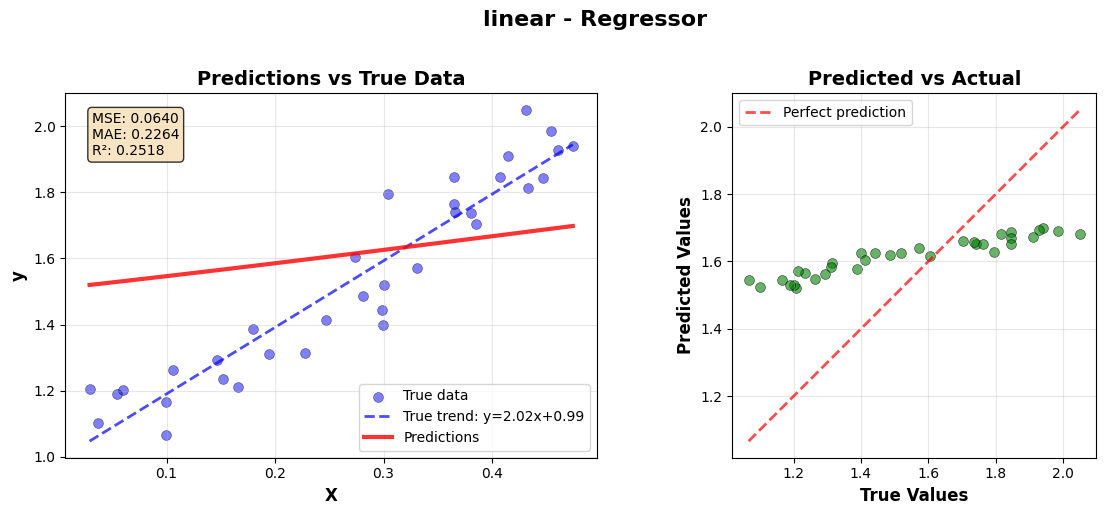

Test results: [1.5907612  1.72611799 1.54212874 1.54212352 1.51342557 1.73065638
 1.54807922 1.62542855 1.60391324 1.58889848 1.62297568 1.64127106
 1.5452748  1.52270983 1.72964543 1.69236671 1.66292499 1.53481078
 1.61854136 1.51629233 1.73057953 1.68447002 1.72346409 1.52766063
 1.55082749 1.57959773 1.56748355 1.58671371 1.53886891 1.66828024
 1.53349021 1.57956455 1.66979321]


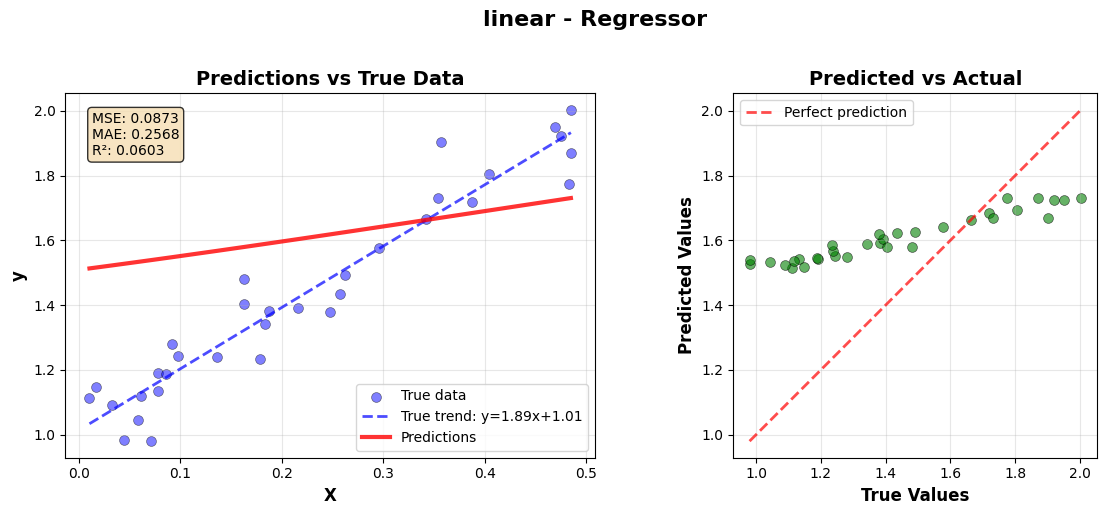

Test results: [1.67211831 1.70119069 1.55293254 1.57679577 1.64971242 1.54388639
 1.69013757 1.52441727 1.57975887 1.53506211 1.61021759 1.56964986
 1.58133364 1.62849929 1.55358417 1.52416536 1.57452284 1.63371022
 1.69411808 1.73719727 1.68711372 1.51604795 1.53012896 1.65237025
 1.52795202 1.58117183 1.65568477 1.71398813 1.61752771 1.68681498
 1.62911224 1.6073521  1.52010106]


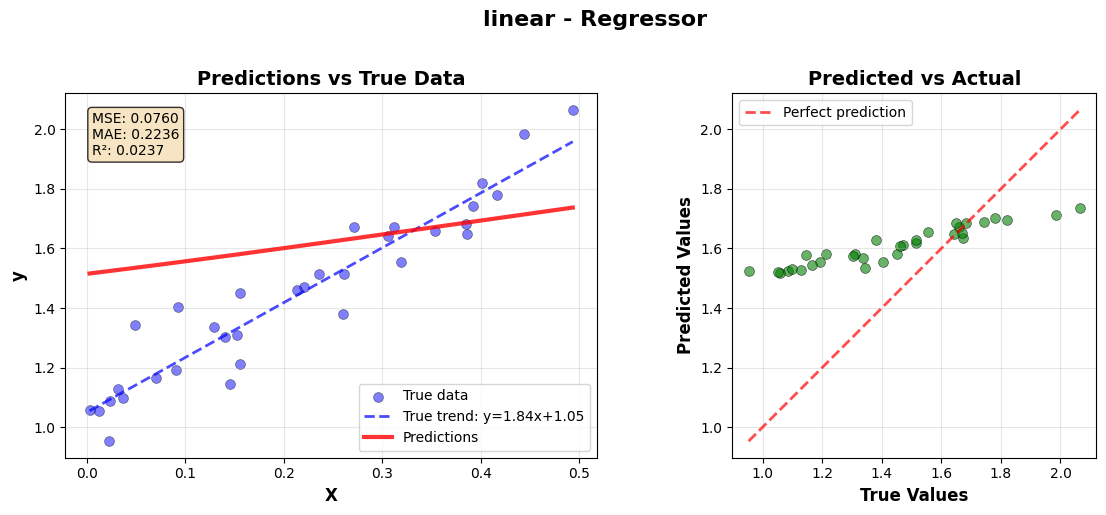


 SEED = 1
Test results: [1.65464899 1.48255631 1.60248653 1.54511617 1.59985841 1.51656164
 1.49245064 1.70918137 1.67393256 1.54833693 1.64258819 1.58145
 1.53735029 1.55004874 1.66554127 1.70684027 1.62082803 1.49773368
 1.67905791 1.60697402 1.67236923 1.71863173 1.67571315 1.561391
 1.68770411 1.62722043 1.55468987 1.54987285 1.66191939 1.61163009
 1.66448984 1.59476221 1.57833514 1.50213943]


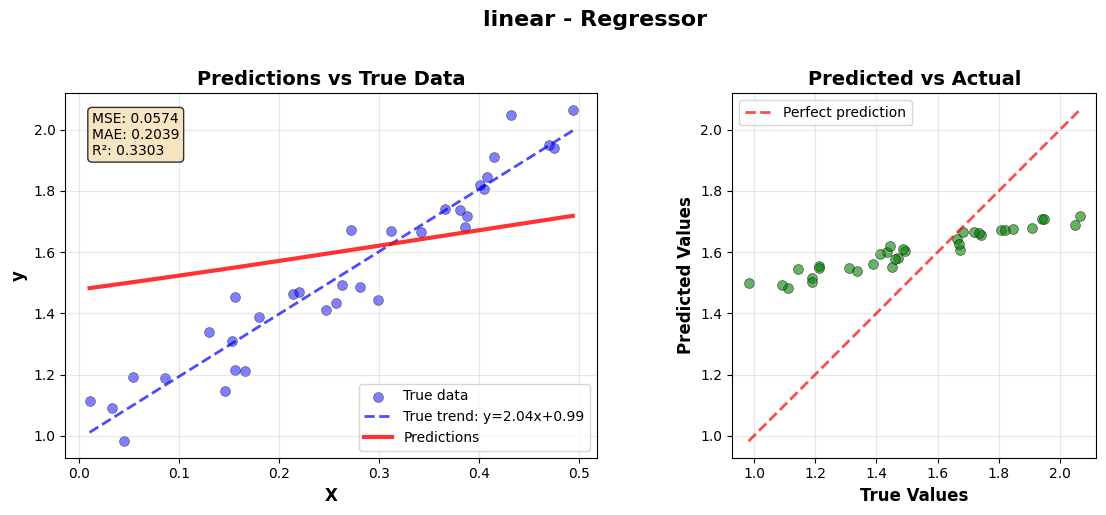

Test results: [1.64151748 1.55282286 1.64202694 1.55807704 1.54967105 1.59406906
 1.61220046 1.56121616 1.64336102 1.71846371 1.5463573  1.6201863
 1.5299722  1.70661072 1.65480086 1.62529222 1.63077573 1.55835628
 1.70355914 1.70925385 1.53197458 1.58587344 1.5499433  1.67777216
 1.66406373 1.53733161 1.53537671 1.66882741 1.64959912 1.70195585
 1.61549178 1.6654006  1.52832044]


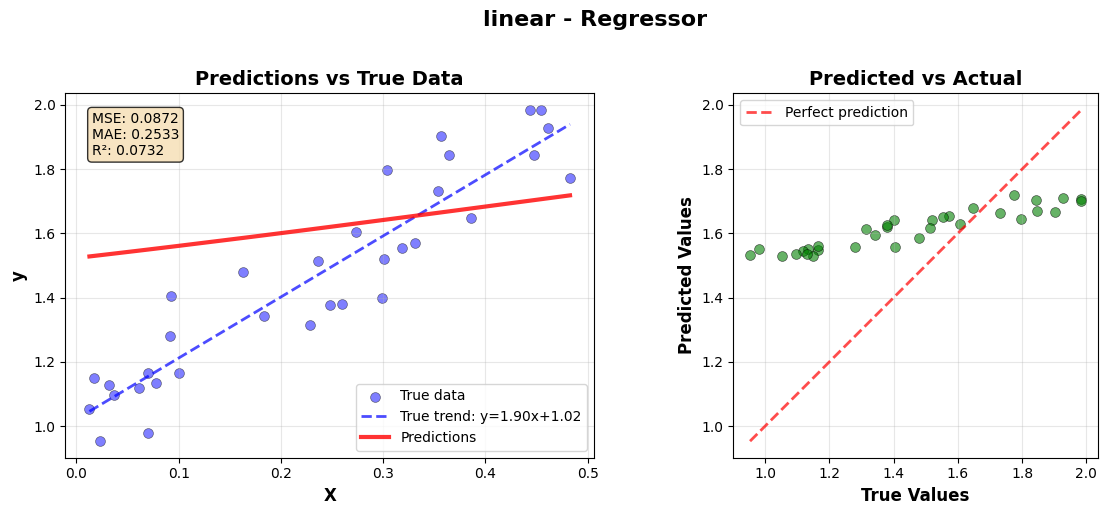

Test results: [1.59531793 1.73808121 1.54392444 1.52189544 1.71702755 1.67750948
 1.74284442 1.70860212 1.55690553 1.54984956 1.57849694 1.60922106
 1.65352509 1.57562748 1.69678526 1.64869746 1.51932629 1.53071713
 1.74276379 1.55311593 1.59872886 1.57071352 1.59103929 1.57297558
 1.52555026 1.55374792 1.51037427 1.68274076 1.69330781 1.53481162
 1.58348217 1.53565282 1.63146213]


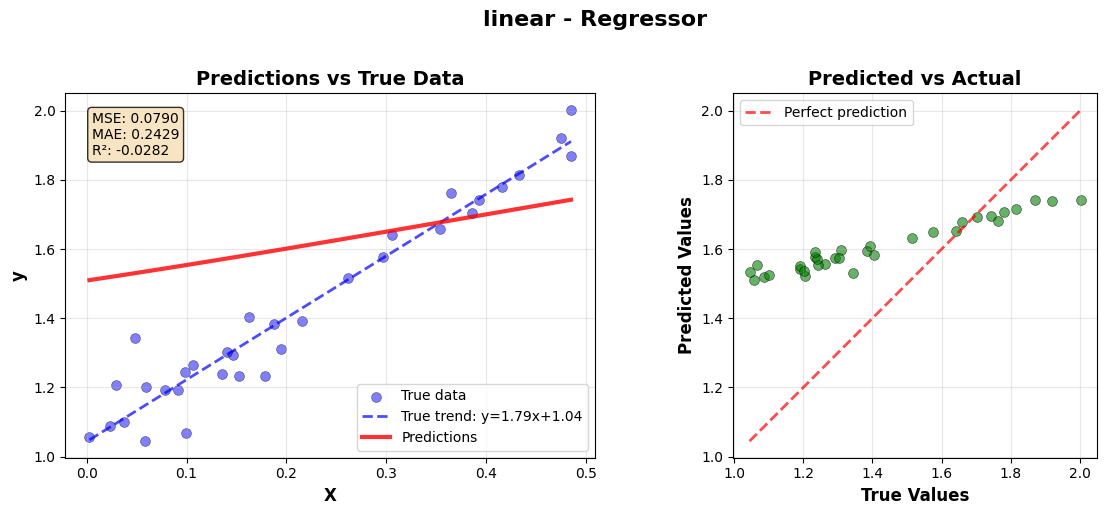


 SEED = 2
Test results: [1.59184162 1.72896196 1.67643208 1.6445196  1.54255073 1.73355433
 1.55500577 1.54823638 1.57571331 1.60517176 1.53894093 1.58995368
 1.61081192 1.68921169 1.62449172 1.64303249 1.51893156 1.64663747
 1.69479463 1.56541242 1.63217438 1.52789801 1.56824948 1.69968485
 1.63122319 1.69649304 1.67039831 1.68586895 1.52480235 1.53380373
 1.52256484 1.5772495  1.68334887 1.53207747]


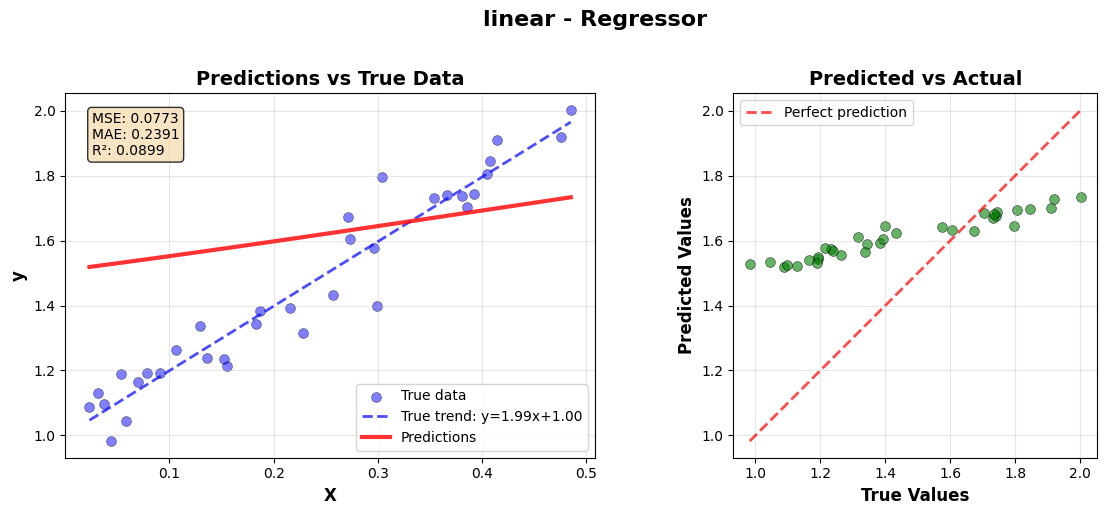

Test results: [1.52180893 1.64985277 1.67631903 1.51362257 1.70720192 1.63109047
 1.57494655 1.55365867 1.52334227 1.5780983  1.62386431 1.66502846
 1.74114528 1.72267307 1.6490601  1.72936685 1.55281106 1.58299491
 1.59809702 1.57252896 1.55343856 1.59087114 1.71481013 1.68166311
 1.65885139 1.61827378 1.53547097 1.67760234 1.69193436 1.62352752
 1.63059529 1.60744998 1.5146717 ]


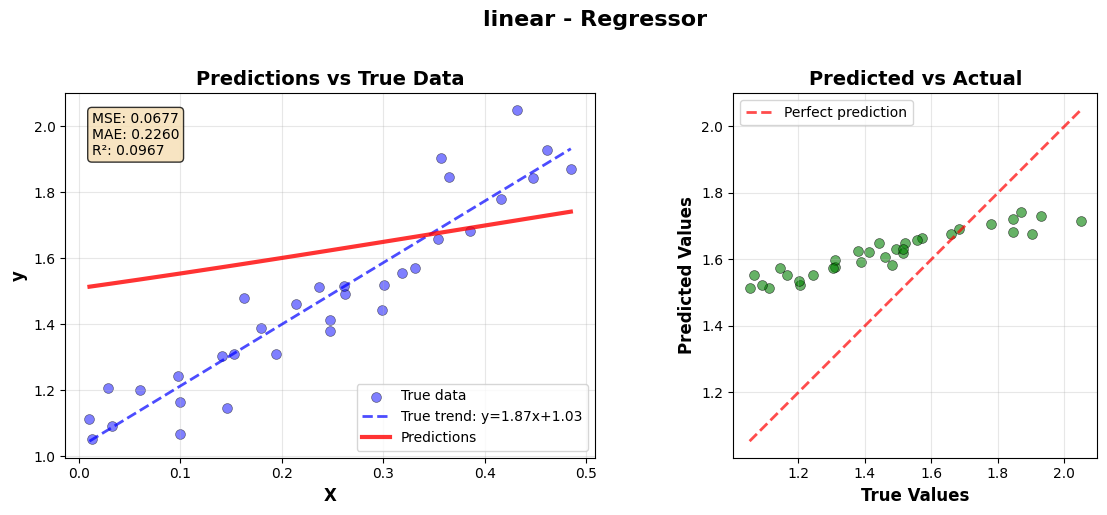

Test results: [1.54234095 1.67283569 1.54708426 1.62474625 1.56622061 1.54484933
 1.68860285 1.69179755 1.5323454  1.63834041 1.59295168 1.53650098
 1.52168309 1.68105722 1.56971192 1.6076599  1.54733629 1.65552885
 1.68681235 1.52349552 1.57780029 1.53974046 1.66066592 1.52842758
 1.69585253 1.65498112 1.51688465 1.6467929  1.62688945 1.5731488
 1.57212379 1.67684327 1.61530789]


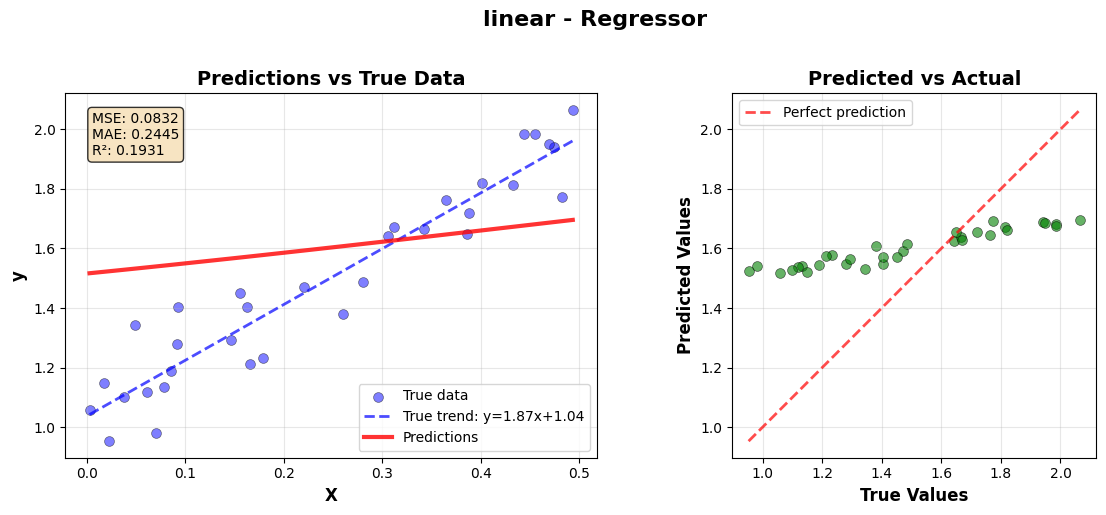



Average MSE across 3 runs: 0.0755 ± 0.0007
Average MAE across 3 runs: 0.2352 ± 0.0013
Average R² across 3 runs: 0.1212 ± 0.0066
Average Negativity: -0.0000 ± 0.0000

Weights saved in: linear_weights_2025-11-27_23-35-46.csv

REGRESSION METRICS SUMMARY
Model: Linha
Dataset: linear
Configuration: 3 runs × 3-fold CV

Metric     Mean         Std          Min          Max         
----------------------------------------------------------------------
MSE        0.075451     0.000658     0.074536     0.076053    
MAE        0.235176     0.001325     0.233386     0.236551    
R²         0.121196     0.006564     0.111953     0.126565    

📁 Results saved to:
   - results/Linha_linear_results_20251127_233546.csv
   - results/Linha_linear_summary_20251127_233546.csv
   - results/Linha_linear_metrics_plot_20251127_233546.png


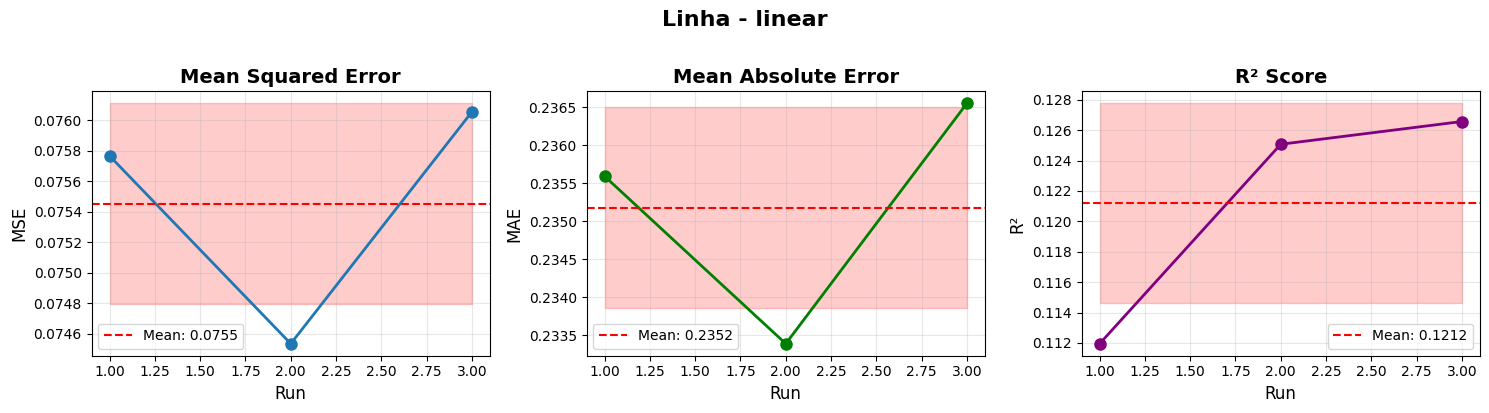

   - results/Linha_linear_report_20251127_233546.txt

✅ All results saved successfully!



{'mse': {'mean': np.float64(0.07545140335996912),
  'std': np.float64(0.0006576071342674481),
  'min': np.float64(0.07453642872134945),
  'max': np.float64(0.07605306686514635)},
 'mae': {'mean': np.float64(0.23517559854923265),
  'std': np.float64(0.0013247652383689367),
  'min': np.float64(0.2333860470628615),
  'max': np.float64(0.23655061747394837)},
 'r2': {'mean': np.float64(0.12119579645016239),
  'std': np.float64(0.006563905611506458),
  'min': np.float64(0.11195328200123393),
  'max': np.float64(0.12656487070516323)}}

In [ ]:
import numpy as np
import math

# Configuration
n_times_kfold = 3
k_times_fold = 3
N_FEATURES = 1
str_DF = 'Linha'
# Use regressor function (not classifier)
regressor_function = iqc_regressor

# Regressor parameters (renamed from dic_classifier_params)
dic_regressor_params = {}
dic_regressor_params["sigma_q_params"] = [1, 1, 1, 0]
dic_regressor_params["use_polar_coordinates_on_sigma_q"] = False
dic_regressor_params["load_inputvector_env_state"] = False
dic_regressor_params["normalize_axis"] = 1
dic_regressor_params["N_qubits"] = math.ceil(np.log2(N_FEATURES) + 1)

# Training parameters (updated for regression)
dic_training_params = {
    "max_iter": 200,
    "mse_threshold": 0.01,  # Changed from accuracy_succ
    "plot_graphs_and_metrics": False,
    "plot_graphs_in_regressor": False,
    "random_seed": 1,
    "learning_rate": 0.01,
    "reset_weights_epoch": 0,
    "batch": 1,  # Batch 1
    "coupling_constants": [1],
}

# Initialize lists for metrics
mse_scores_list = []  # Changed from scores_list
mae_scores_list = []  # Changed from f1scores_list
r2_scores_list = []   # Added for R² scores
negativities_list = []
weights_list = []

# Run k-fold cross-validation multiple times with different seeds
for SEED in range(n_times_kfold):
    print('\n', f'SEED = {SEED}')

    # Execute k-fold cross-validation for regression
    mse_scores, mae_scores, r2_scores, output_dict, weights = execute_training_test_k_fold_regressor(
        X=X,
        y=y,
        k_folds=k_times_fold,
        random_seed=SEED,
        regressor_function=regressor_function,
        dic_regressor_params=dic_regressor_params,
        dic_training_params=dic_training_params,
        print_each_fold_metric=False,
        print_avg_metric=False
    )

    # Store results
    mse_scores_list.append(np.mean(mse_scores))
    mae_scores_list.append(np.mean(mae_scores))
    r2_scores_list.append(np.mean(r2_scores))

    # Handle negativities if they exist
    if output_dict["negativities"]:
        negativities_list.append(np.mean(output_dict["negativities"]))

    weights_list.append(np.array(weights))

# Print and save results
print("\n" + "="*60)
print("="*60)

print(f"\nAverage MSE across {n_times_kfold} runs: {np.mean(mse_scores_list):.4f} ± {np.std(mse_scores_list):.4f}")
print(f"Average MAE across {n_times_kfold} runs: {np.mean(mae_scores_list):.4f} ± {np.std(mae_scores_list):.4f}")
print(f"Average R² across {n_times_kfold} runs: {np.mean(r2_scores_list):.4f} ± {np.std(r2_scores_list):.4f}")

if negativities_list:
    print(f"Average Negativity: {np.mean(negativities_list):.4f} ± {np.std(negativities_list):.4f}")

# Save results (you'll need to adapt your save functions)
print_and_save_weights(weights_list, "linear")

# Save regression metrics (adapt your function)
print_and_save_regression_metrics(
    mse_scores_list,
    mae_scores_list,
    r2_scores_list,
    n_times_kfold,
    k_times_fold,
    str_DF,
    print_all=False
)